<a href="https://colab.research.google.com/github/huihuiwuwu/Github-Colab/blob/main/%ED%86%A0%ED%94%BD%EB%B6%84%EC%84%9D(%EC%B5%9C%EC%A2%85_%EC%BD%94%EB%93%9C_%EC%A7%91%ED%95%A9).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 토픽분석을 위한 전처리

In [ ]:
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import site
import os
import pandas as pd
import re
from tqdm import tqdm

In [ ]:
!pip install pyLDAvis

In [ ]:
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from gensim import corpora
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.gensim_models
import gensim

In [ ]:
All_data=pd.read_csv('/content/drive/MyDrive/졸업논문/AI Media/All_data.csv')

In [ ]:
All_data=All_data.rename(columns={'x':'Contents'})

In [ ]:
stopwords_df = pd.read_excel("/content/drive/MyDrive/졸업논문/AI Media/stopwords.xlsx")

In [ ]:
TARGET_COL = "Contents"
PROCESSED_COL = "ProcessedData"

In [ ]:
# 데이터의 결측값 여부 확인
print(f'충 데이터(row)의 수:{len(All_data)}')

print(f"\n===== {TARGET_COL} column의 결측값 여부 확인 =====")
print('결측값 여부 :', All_data[TARGET_COL].isnull().values.any())
print(f"원본 데이터의 유니크한 값 : {All_data[TARGET_COL].nunique()}")

## 토픽을 위한 전처리

In [ ]:
All_data[PROCESSED_COL]=[False for _ in range(len(All_data[TARGET_COL]))]

In [ ]:
# 개행 문자 (CRLF) 제거
def remove_CRLF(input_str):
    input_str = input_str.replace("\n", " ")
    input_str = input_str.replace("\n", " ")
    input_str = input_str.replace("\r", " ")
    input_str = input_str.replace("\r", " ")

    return input_str

In [ ]:
for i in range(len(All_data[TARGET_COL])):
    All_data[PROCESSED_COL][i] = remove_CRLF(All_data[TARGET_COL][i])

In [ ]:
# 이모티콘 문자들, 사이트 URL주소, 의미없는 문자 지우기
def cleansing(input_str):
    output_str = re.sub(pattern='<[U]\+[A-Z0-9]*>', repl=' ', string=input_str)
    output_str = re.sub(pattern='http[s]?://(?:[a-zA-Z]|[0-9]|[_$\-@\.&+:/?=]|[!*,]|(?:%[0-9a-fA-F_][0-9a-fA-F_]))+', repl=' ', string=output_str)
    output_str = re.sub(pattern='^[0-9]+$', repl=' ', string=output_str)

    return output_str

In [ ]:
for i in range(len(All_data[TARGET_COL])):
    All_data[PROCESSED_COL][i] = cleansing(All_data[PROCESSED_COL][i])

In [ ]:
 데이터의 앞뒤에 공백 추가
def add_space(input_str):
    return " "+input_str+" "

In [ ]:
for i in range(len(All_data[TARGET_COL])):
    All_data[PROCESSED_COL][i] = add_space(All_data[PROCESSED_COL][i])

In [ ]:
 불용어 제거 단계
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
stop_words = set(stopwords_df['stopword'].str.lower())

In [ ]:
# 불용어 제거 함수 정의
def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.casefold() not in stop_words]
    return ' '.join(filtered_text)

In [ ]:
for i in tqdm(range(len(All_data[TARGET_COL]))):
    All_data[PROCESSED_COL][i] = remove_stopwords(All_data[PROCESSED_COL][i])

In [ ]:
All_data.to_csv('/content/drive/MyDrive/졸업논문/AI Media/remove_stopwords.csv',index=False)

In [ ]:
All_data2=pd.read_csv('/content/drive/MyDrive/졸업논문/AI Media/remove_stopwords.csv') #제대로 저장된지 확인

## 토큰화 단계

In [ ]:
# 토큰화_명사만 남기기 (*mecab.morphs를 사용해 나온 결과는 별로였어서 아래처름 mecab.nouns로 명사만 추출)
def tokenize_and_filter(text):
    tokens = mecab.nouns(text)  # 텍스트에서 명사만 추출합니다
    tokens = [token for token in tokens if len(token) > 1]  # 길이가 1보다 큰 토큰만 선택합니다
    return tokens

In [ ]:
for i in tqdm(range(len(All_data2[TARGET_COL]))):
    # List of strings to single string
    if isinstance(All_data2[PROCESSED_COL][i], list):
        input_string = ' '.join(All_data2[PROCESSED_COL][i])
    else:
        input_string = All_data2[PROCESSED_COL][i]
    All_data2[PROCESSED_COL][i] = tokenize_and_filter(input_string)

In [ ]:
All_data2.to_csv('/content/drive/MyDrive/졸업논문/AI Media/tokenize(mecab_noun)_words.csv',index=False)

In [ ]:
# mecab로 1보다 큰 명사만 추출된 파일 불어오기
data=pd.read_csv('/content/drive/MyDrive/졸업논문/AI Media/tokenize(mecab_noun)_words.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data[:5]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Contents,ProcessedData
0,전산망 ‘먹통’ 사고가 또 났다. 지난 30일 서울 강남고속버스터미널 버스표 발권 ...,"['전산망', '먹통', '사고', '강남', '고속버스', '터미널', '버스표'..."
1,‘IT 강국 대한민국’이지만 첨단 IT를 활용한 법률서비스인 ‘리걸테크 산업’은 걸...,"['강국', '대한민국', '첨단', '활용', '법률', '서비스', '리걸', ..."
2,살아있는 동물처럼 네 다리로 걷고 계단과 비탈길에서 자유자재로 움직이는 로봇을 제조...,"['동물', '다리', '계단', '비탈길', '자유자재', '제조', '보스턴',..."
3,대전 동구 역세권지구에 한국기상산업기술원 이전이 가시화되면서 '기상산업 클러스터' ...,"['대전', '동구', '역세', '지구', '한국', '기상', '산업', '기술..."
4,국내 데이터 네트워크 인공지능(AI) 생태계가 급성장하며 SW AI 역량을 갖춘 이...,"['국내', '데이터', '네트워크', '인공지능', '생태', '급성장', '역량..."


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data.info()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320049 entries, 0 to 1320048
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Contents       1320049 non-null  object
 1   ProcessedData  1320049 non-null  object
dtypes: object(2)
memory usage: 20.1+ MB


In [ ]:
# 토픽 모델링
# 1. 최적의 토픽 수 계산
coherence_values = []
model_list = []

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    for num_topics in range(start, limit, step):
#         model = pyLDAvis.gensim_models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
def find_optimal_number_of_topics(dictionary, corpus, processed_data, limit=8):
    start = 1;
    step = 1;

    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step)

    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')

    dic = { coherence_values:x for x, coherence_values in zip(x, coherence_values) }

    plt.text(dic[max(coherence_values)],min(coherence_values),
             str(dic[max(coherence_values)]) + ' at MAX',
             color='r',
             horizontalalignment='center',
             verticalalignment='bottom')

    plt.show()

    return dic[max(coherence_values)]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# 상위 1,000개의 단어를 보존
TARGET_COL = "contents"
PROCESSED_COL = "ProcessedData"

vectorizer = TfidfVectorizer(stop_words='english', max_features= 1000)
X = vectorizer.fit_transform(data[PROCESSED_COL])

In [ ]:
dictionary = corpora.Dictionary(data['ProcessedData'])
corpus = [dictionary.doc2bow(text) for text in data['ProcessedData']]
processed_data = data['ProcessedData'].tolist()

In [ ]:
limit = 8
NUM_TOPICS = find_optimal_number_of_topics(dictionary, corpus, processed_data, limit)

In [ ]:
# LDA모델 생성
lda_model = LatentDirichletAllocation(n_components=6, learning_method='online', random_state=42, max_iter=1)
lda_top = lda_model.fit_transform(X)

In [ ]:
# 단어 집합. 1,000개의 단어가 저장됨.
terms = vectorizer.get_feature_names_out()

def get_topics2(components, terms):
    topics = []
    for topic_idx, topic in enumerate(components):
        topic_terms = [(terms[i], topic[i]) for i in topic.argsort()[:-20 - 1:-1]]
        topics.append((topic_idx, topic_terms))
    return topics

In [ ]:
topics = get_topics2(lda_model.components_, terms)
if topics is not None:
    df = pd.DataFrame(topics, columns=['Topic', 'Terms'])
else:
    df = pd.DataFrame()

In [ ]:
topics_transformed = [(topic[0], word, value) for topic in topics for word, value in topic[1]]
df = pd.DataFrame(topics_transformed, columns=['Topic', 'Word', 'Value'])
df.to_csv('/content/drive/MyDrive/졸업논문/AI Media/topics6_mecab_noun.csv',index=False)

## AI, Media 데이터를 재확인

In [ ]:
AI=pd.read_csv('/content/drive/MyDrive/졸업논문/AI Media/AI.csv')
Media=pd.read_csv('/content/drive/MyDrive/졸업논문/AI Media/media.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(len(AI))
print(len(Media))

83751
48253


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
AI.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,x
83746,83747,"""2040년 '개교 100주년'을 향한 힘찬 날갯짓을 멈추지 않겠습니다."" \n\n..."
83747,83748,[천안]남서울대학교 김의명 드론공간정보공학과 교수와 임상병리학과 이동하 교수가 지난...
83748,83749,현대자동차가 신입 상시채용 제도에 지원자의 편의성을 높일 새로운 공고 게시 방식을 ...
83749,83750,한밭대 컴퓨터공학과에 재학 중인 김민준 씨가 한국장학재단에서 수여하는 '대통령과학장...
83750,83751,KT가 'KT Bridge Lab 대전센터' 개소로 대전ㆍ충청권 유망 스타트업 발굴...


## Topic analysis for AI data

In [ ]:
selected_data_AI = data.head(83751)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
selected_data_AI.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Contents,ProcessedData
0,전산망 ‘먹통’ 사고가 또 났다. 지난 30일 서울 강남고속버스터미널 버스표 발권 ...,"['전산망', '먹통', '사고', '강남', '고속버스', '터미널', '버스표'..."
1,‘IT 강국 대한민국’이지만 첨단 IT를 활용한 법률서비스인 ‘리걸테크 산업’은 걸...,"['강국', '대한민국', '첨단', '활용', '법률', '서비스', '리걸', ..."
2,살아있는 동물처럼 네 다리로 걷고 계단과 비탈길에서 자유자재로 움직이는 로봇을 제조...,"['동물', '다리', '계단', '비탈길', '자유자재', '제조', '보스턴',..."
3,대전 동구 역세권지구에 한국기상산업기술원 이전이 가시화되면서 '기상산업 클러스터' ...,"['대전', '동구', '역세', '지구', '한국', '기상', '산업', '기술..."
4,국내 데이터 네트워크 인공지능(AI) 생태계가 급성장하며 SW AI 역량을 갖춘 이...,"['국내', '데이터', '네트워크', '인공지능', '생태', '급성장', '역량..."


In [ ]:
selected_data_AI.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Contents,ProcessedData
83746,"""2040년 '개교 100주년'을 향한 힘찬 날갯짓을 멈추지 않겠습니다."" \n\n...","['개교', '주년', '날갯짓', '효인', '대전', '학기', '술대', '총..."
83747,[천안]남서울대학교 김의명 드론공간정보공학과 교수와 임상병리학과 이동하 교수가 지난...,"['천안', '서울', '대학교', '김의명', '드론', '공간', '정보', '..."
83748,현대자동차가 신입 상시채용 제도에 지원자의 편의성을 높일 새로운 공고 게시 방식을 ...,"['현대', '자동차', '신입', '시채', '제도', '지원자', '편의', '..."
83749,한밭대 컴퓨터공학과에 재학 중인 김민준 씨가 한국장학재단에서 수여하는 '대통령과학장...,"['한밭', '컴퓨터', '공학', '재학', '김민준', '한국장학재단', '수여..."
83750,KT가 'KT Bridge Lab 대전센터' 개소로 대전ㆍ충청권 유망 스타트업 발굴...,"['대전', '센터', '개소', '대전', '유망', '스타트업', '발굴', '..."


In [ ]:
AI_data = selected_data_AI

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
AI_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83751 entries, 0 to 83750
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Contents       83751 non-null  object
 1   ProcessedData  83751 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
AI_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Contents,ProcessedData
0,전산망 ‘먹통’ 사고가 또 났다. 지난 30일 서울 강남고속버스터미널 버스표 발권 ...,"['전산망', '먹통', '사고', '강남', '고속버스', '터미널', '버스표'..."
1,‘IT 강국 대한민국’이지만 첨단 IT를 활용한 법률서비스인 ‘리걸테크 산업’은 걸...,"['강국', '대한민국', '첨단', '활용', '법률', '서비스', '리걸', ..."
2,살아있는 동물처럼 네 다리로 걷고 계단과 비탈길에서 자유자재로 움직이는 로봇을 제조...,"['동물', '다리', '계단', '비탈길', '자유자재', '제조', '보스턴',..."
3,대전 동구 역세권지구에 한국기상산업기술원 이전이 가시화되면서 '기상산업 클러스터' ...,"['대전', '동구', '역세', '지구', '한국', '기상', '산업', '기술..."
4,국내 데이터 네트워크 인공지능(AI) 생태계가 급성장하며 SW AI 역량을 갖춘 이...,"['국내', '데이터', '네트워크', '인공지능', '생태', '급성장', '역량..."


In [ ]:
# 토픽 모델링
# 1. 최적의 토픽 수 계산
coherence_values = []
model_list = []

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    for num_topics in range(start, limit, step):
#         model = pyLDAvis.gensim_models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def find_optimal_number_of_topics(dictionary, corpus, processed_data, limit=8):
    start = 1;
    step = 1;

    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step)

    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')

    dic = { coherence_values:x for x, coherence_values in zip(x, coherence_values) }

    plt.text(dic[max(coherence_values)],min(coherence_values),
             str(dic[max(coherence_values)]) + ' at MAX',
             color='r',
             horizontalalignment='center',
             verticalalignment='bottom')

    plt.show()

    return dic[max(coherence_values)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 상위 1,000개의 단어를 보존
TARGET_COL = "contents"
PROCESSED_COL = "ProcessedData"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features= 1000)
X = vectorizer.fit_transform(AI_data[PROCESSED_COL])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import ast

AI_data['ProcessedData'] = AI_data['ProcessedData'].apply(ast.literal_eval)

dictionary = corpora.Dictionary(AI_data['ProcessedData'])

corpus = [dictionary.doc2bow(text) for text in AI_data['ProcessedData']]

processed_data = AI_data['ProcessedData'].tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


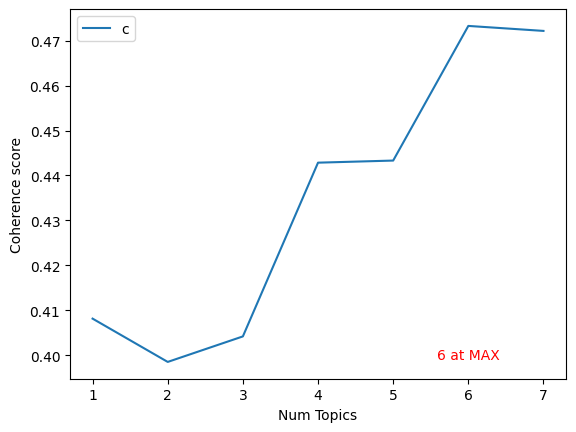

In [ ]:
limit = 8
NUM_TOPICS = find_optimal_number_of_topics(dictionary, corpus, processed_data, limit)

In [ ]:
# LDA모델 생성
lda_model = LatentDirichletAllocation(n_components=6, learning_method='online', random_state=42, max_iter=1)
lda_top = lda_model.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 단어 집합. 1,000개의 단어가 저장됨.
terms = vectorizer.get_feature_names_out()

def get_topics(components, feature_names, n=20):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
AI_topics6_mecab_noun=get_topics(lda_model.components_,terms)

Topic 1: [('산업', 1503.52), ('사업', 1362.74), ('기술', 1315.79), ('지원', 937.5), ('과학', 913.27), ('혁신', 888.52), ('정부', 879.74), ('기업', 868.88), ('정보', 782.26), ('한국', 772.13), ('디지털', 744.26), ('경제', 726.46), ('선정', 723.54), ('분야', 689.54), ('미래', 678.97), ('반도체', 618.4), ('추진', 608.33), ('지역', 603.92), ('인공지능', 580.3), ('개최', 571.88)]
Topic 2: [('교육', 1490.32), ('대통령', 1130.72), ('윤석열', 834.18), ('후보', 657.93), ('학생', 608.19), ('대학', 582.88), ('교육감', 573.28), ('교수', 496.92), ('학교', 481.41), ('국민', 478.27), ('과정', 419.08), ('선거', 412.97), ('교육청', 383.55), ('대학교', 367.58), ('광주', 353.2), ('기자', 340.46), ('공약', 318.58), ('학과', 309.16), ('방송', 302.88), ('프로그램', 290.43)]
Topic 3: [('투자', 1262.95), ('미국', 758.05), ('스타트업', 625.73), ('중국', 572.76), ('반도체', 486.66), ('기업', 485.05), ('금융', 480.1), ('뉴스', 439.17), ('일본', 415.04), ('기사', 378.94), ('규모', 363.76), ('인간', 329.22), ('인수', 326.0), ('그룹', 313.36), ('글로벌', 296.8), ('유치', 290.94), ('펀드', 279.72), ('벤처', 275.61), ('시장', 274.45), ('자산', 262.2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def get_topics2(components, terms):
    topics = []
    for topic_idx, topic in enumerate(components):
        topic_terms = [(terms[i], topic[i]) for i in topic.argsort()[:-20 - 1:-1]]
        topics.append((topic_idx, topic_terms))
    return topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
AI_topics = get_topics2(lda_model.components_, terms)
if AI_topics is not None:
    df = pd.DataFrame(AI_topics, columns=['Topic', 'Terms'])
else:
    df = pd.DataFrame()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# print(type(AI_topics))

<class 'list'>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
AI_topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  [('산업', 1503.521821736712),
   ('사업', 1362.7389645557164),
   ('기술', 1315.7883290901966),
   ('지원', 937.4970146277542),
   ('과학', 913.2727554766263),
   ('혁신', 888.5224130850409),
   ('정부', 879.7404631239724),
   ('기업', 868.875532313342),
   ('정보', 782.2581699561559),
   ('한국', 772.1332367688574),
   ('디지털', 744.2627848360949),
   ('경제', 726.4605201645212),
   ('선정', 723.5437757631855),
   ('분야', 689.54276684662),
   ('미래', 678.9699684948592),
   ('반도체', 618.4047611637302),
   ('추진', 608.3263835471216),
   ('지역', 603.9233438247836),
   ('인공지능', 580.2966949713148),
   ('개최', 571.8827508332336)]),
 (1,
  [('교육', 1490.317912380254),
   ('대통령', 1130.7226597676358),
   ('윤석열', 834.1846063777936),
   ('후보', 657.9268506911126),
   ('학생', 608.1903704146148),
   ('대학', 582.8795009137601),
   ('교육감', 573.280040214869),
   ('교수', 496.91626283370283),
   ('학교', 481.4056041808638),
   ('국민', 478.26589858246615),
   ('과정', 419.0816262053069),
   ('선거', 412.97149385278516),
   ('교육청', 383.5530

In [ ]:
topics_transformed = [(topic[0], word, value) for topic in AI_topics for word, value in topic[1]]
df = pd.DataFrame(topics_transformed, columns=['Topic', 'Word', 'Value'])
df.to_csv('/content/drive/MyDrive/졸업논문/AI Media/토픽분석_결과/AI_topics.csv',index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Topics analysis for Media data

In [ ]:
selected_data_Media = data.tail(48235)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
selected_data_Media.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Contents,ProcessedData
1271814,내일부터 만 16세 미만 청소년의 심야 시간대 온라인 게임 이용을 금지한 ‘게임셧다...,"['내일', '미만', '청소년', '심야', '시간', '온라인', '게임', '..."
1271815,[머니투데이 고석용 기자] 경찰이 법률 플랫폼 '로톡'과 관련해 변호사법을 위반하지...,"['고석용', '기자', '경찰', '법률', '플랫', '관련', '변호사법', ..."
1271816,나라를 구했다는 ‘삼프로TV’ 인기가 말하는 것\n\n\n\n‘삼프로TV가 나라를 ...,"['나라', '프로', '인기', '프로', '나라', '경제', '주식', '유튜..."
1271817,"올해 글로벌 인수합병(M&A) 규모가 5조 8,000억 달러(약 6,900조 원)로...","['글로벌', '인수', '합병', '규모', '달러', '조사', '시작', '사..."
1271818,방탄소년단(BTS) 소속사 하이브의 대체 불가 토큰(NFT) 사업 진출을 두고 일부...,"['방탄소년단', '소속', '하이브', '대체', '불가', '토큰', '사업',..."


In [ ]:
selected_data_Media.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Contents,ProcessedData
1320044,공주시가 국립공주대학교 공주학연구원(원장 유석호)과 함께 개최하는 '2022 디지털...,"['공주', '국립', '공주', '대학교', '공주', '학연', '구원', '원..."
1320045,시스코시스템즈가 클라우드 시대에 접어들면서 전통적인 네트워크장비 공급업체에서 소프트...,"['시스코', '시스템즈', '클라우드', '시대', '전통', '네트워크', '장..."
1320046,"네이버 등 소셜미디어 인증 통해 \n서울시, 과태료 납부 서비스 제공 \n\n \n...","['네이버', '소셜', '미디어', '인증', '서울시', '과태료', '납부',..."
1320047,오는 9월16일까지 주프랑스한국문화원에서 개최하는 <연등회: 빛과 색의 향연> 특별...,"['프랑스', '한국', '문화원', '개최', '연등회', '향연', '특별', ..."
1320048,광주 동구에 위치한 국윤미술관이 오는 6월 23일까지 이상필 작가를 초대해 '미디어...,"['광주', '동구', '위치', '미술관', '이상필', '작가', '초대', '..."


In [ ]:
data.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Contents,ProcessedData
1320044,공주시가 국립공주대학교 공주학연구원(원장 유석호)과 함께 개최하는 '2022 디지털...,"['공주', '국립', '공주', '대학교', '공주', '학연', '구원', '원..."
1320045,시스코시스템즈가 클라우드 시대에 접어들면서 전통적인 네트워크장비 공급업체에서 소프트...,"['시스코', '시스템즈', '클라우드', '시대', '전통', '네트워크', '장..."
1320046,"네이버 등 소셜미디어 인증 통해 \n서울시, 과태료 납부 서비스 제공 \n\n \n...","['네이버', '소셜', '미디어', '인증', '서울시', '과태료', '납부',..."
1320047,오는 9월16일까지 주프랑스한국문화원에서 개최하는 <연등회: 빛과 색의 향연> 특별...,"['프랑스', '한국', '문화원', '개최', '연등회', '향연', '특별', ..."
1320048,광주 동구에 위치한 국윤미술관이 오는 6월 23일까지 이상필 작가를 초대해 '미디어...,"['광주', '동구', '위치', '미술관', '이상필', '작가', '초대', '..."


In [ ]:
Media_data = selected_data_Media

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features= 1000)
X = vectorizer.fit_transform(Media_data[PROCESSED_COL])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
coherence_values = []
model_list = []

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    for num_topics in range(start, limit, step):
#         model = pyLDAvis.gensim_models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def find_optimal_number_of_topics(dictionary, corpus, processed_data, limit=8):
    start = 1;
    step = 1;

    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step)

    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')

    dic = { coherence_values:x for x, coherence_values in zip(x, coherence_values) }

    plt.text(dic[max(coherence_values)],min(coherence_values),
             str(dic[max(coherence_values)]) + ' at MAX',
             color='r',
             horizontalalignment='center',
             verticalalignment='bottom')

    plt.show()

    return dic[max(coherence_values)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import ast

Media_data['ProcessedData'] = Media_data['ProcessedData'].apply(ast.literal_eval)

dictionary = corpora.Dictionary(Media_data['ProcessedData'])

corpus = [dictionary.doc2bow(text) for text in Media_data['ProcessedData']]

processed_data = Media_data['ProcessedData'].tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


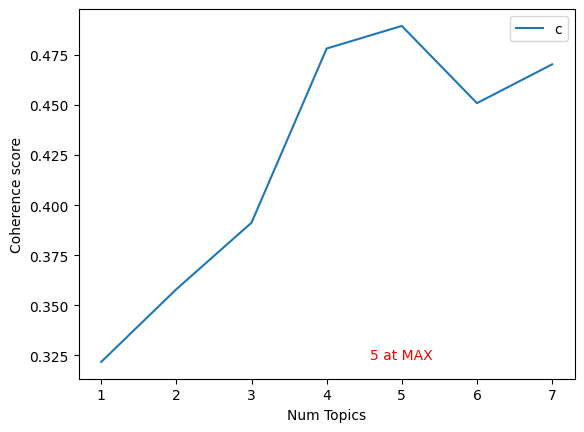

In [ ]:
limit = 8
NUM_TOPICS = find_optimal_number_of_topics(dictionary, corpus, processed_data, limit)

In [ ]:
# LDA모델 생성
lda_model = LatentDirichletAllocation(n_components=5, learning_method='online', random_state=42, max_iter=1)
lda_top = lda_model.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
terms = vectorizer.get_feature_names_out()
def get_topics2(components, terms):
    topics = []
    for topic_idx, topic in enumerate(components):
        topic_terms = [(terms[i], topic[i]) for i in topic.argsort()[:-20 - 1:-1]]
        topics.append((topic_idx, topic_terms))
    return topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
Media_topics = get_topics2(lda_model.components_, terms)
if Media_topics is not None:
    df = pd.DataFrame(Media_topics, columns=['Topic', 'Terms'])
else:
    df = pd.DataFrame()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
Media_topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  [('투자', 904.9936837444027),
   ('기업', 764.6737645135673),
   ('스타트업', 761.9348079359012),
   ('콘텐츠', 695.0674401028085),
   ('플랫', 632.7373452633567),
   ('기자', 510.2682192628726),
   ('기술', 479.8919866090376),
   ('서비스', 458.8665592650404),
   ('글로벌', 452.46936973000817),
   ('국내', 408.20564042202915),
   ('미디어', 400.10970801885094),
   ('메타', 370.497149353631),
   ('벤처', 364.2782446068203),
   ('사업', 363.5621645680228),
   ('대표', 351.19124200164276),
   ('버스', 349.5845013203195),
   ('시장', 347.1209507284285),
   ('드라마', 338.1089439121813),
   ('디지털', 322.6900636362139),
   ('기사', 322.3583015970196)]),
 (1,
  [('미국', 626.2643973004429),
   ('현지', 543.8581952339806),
   ('시간', 472.8714905864321),
   ('중국', 431.0378810908805),
   ('소셜', 322.0264703074633),
   ('러시아', 316.27678960358537),
   ('미디어', 305.8258514999157),
   ('지수', 278.2819350050359),
   ('우크라', 277.64905160959825),
   ('삼성전자', 272.1610413757217),
   ('스타', 255.32052118693844),
   ('그룹', 253.06492090085248),
   ('일본'

In [ ]:
topics_transformed = [(topic[0], word, value) for topic in Media_topics for word, value in topic[1]]
df = pd.DataFrame(topics_transformed, columns=['Topic', 'Word', 'Value'])
df.to_csv('/content/drive/MyDrive/졸업논문/AI Media/토픽분석_결과/Media_topics5.csv',index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
